In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
import optuna
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import sklearn 
import matplotlib.pyplot as plt
import time
import shap

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
xgb.set_config(verbosity=0)
optuna.logging.set_verbosity(optuna.logging.WARNING)

C:\Users\Ryan\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Users\Ryan\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Users\Ryan\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Users\Ryan\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future ver

In [154]:
df = pd.read_csv('/Users/Ryan/Dropbox/Projects/StamfordPropTax_2022/ExtractedData/allProperties.csv')
df.shape

(38714, 295)

Compare distribution of changes in assessment for Single Family homes vs. condos

0.25492298693702475


Text(0.5, 0, '% change in assessment')

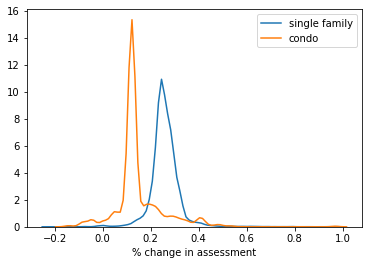

In [156]:
assess_change = (df[df.prop_type.str.contains('Single')].assess_2022-df[df.prop_type.str.contains('Single')].assess_2021)/df[df.prop_type.str.contains('Single')].assess_2021
assess_change = assess_change[assess_change.notna()]
assess_change = assess_change[(assess_change<=1)&(assess_change>-0.5)]
print(np.median(assess_change))
sns.kdeplot(assess_change, label='single family')

assess_change = (df[df.prop_type.str.contains('Res. Condo')].assess_2022-df[df.prop_type.str.contains('Res. Condo')].assess_2021)/df[df.prop_type.str.contains('Res. Condo')].assess_2021
assess_change = assess_change[assess_change.notna()]
assess_change = assess_change[(assess_change<=1)&(assess_change>-0.5)]
sns.kdeplot(assess_change, label='condo')

plt.xlabel('% change in assessment')

**Here we can see that single family homes had a significantly greater incease in valuations than condos.** So we will only include single family homes in the model.

Filter for only single family homes. Also only include homes built before 2018 so they all have a 2017 assessment (last time it was done sity-wide)

In [5]:
df = df[df.prop_type.str.contains('Single Family')]
df = df[df.year_built <2018]

(38714, 295)
(18793, 295)


When extracting the data, some fields had slighly different names for different properties, so here I'm merging all of the columns for duplicated field names

In [6]:
# merge duplicated columns
df['Interior Floor 1'] = df['Interior Floor 1'].fillna(df['Interior Flr 1'])
df['Interior Floor 2'] = df['Interior Floor 2'].fillna(df['Interior Flr 2'])
df['Heating Type'] = df['Heating Type'].fillna(df['Heat Type'])
df['Heating Fuel'] = df['Heating Fuel'].fillna(df['Heat Fuel'])
df['Total Bthrms'] = df['Total Bthrms'].fillna(df['Total Baths'])
df['Total Bthrms'] = df['Total Bthrms'].fillna(df['Ttl Bathrms'])
df['Total Bedrooms'] = df['Total Bedrooms'].fillna(df['Total Bedrms'])
df['Total Bedrooms'] = df['Total Bedrooms'].fillna(df['Ttl Bedrms'])
df['Total Half Baths'] = df['Total Half Baths'].fillna(df['Ttl Half Bths'])

df = df.drop(columns=['Interior Flr 1','Interior Flr 2','Heat Type','Heat Fuel','Total Baths','Ttl Bathrms',
                     'Total Bedrms','Ttl Bedrms','Ttl Half Bths'])

Drop any features with > 10% missing data

In [7]:
nan_thresh = 0.1
df = df.dropna(thresh=len(df)*nan_thresh, axis=1)

Compute change in assessment for all properties and add it to the dataframe

In [9]:
df['assess_change'] = (df.assess_2022-df.assess_2021)/df.assess_2021

Doing some cleanup

In [10]:
df = df.set_index('address', drop=True)

In [11]:
df['Total Bedrooms'] = df['Total Bedrooms'].astype(str).str.replace(' Bedrooms', '').str.replace(' Bedroom', '').astype(float)
df['Total Bthrms'] = df['Total Bthrms'].astype(str).str.replace(' Full', '').astype(float)
df['Total Rooms'] = df['Total Rooms'].astype(str).str.replace(' Rooms','').astype(float)
df.Stories = df.Stories.astype(str).str.replace(' Story', '')
df.Stories = df.Stories.astype(str).str.replace(' Stories', '')
df.Stories = df.Stories.astype(str).str.replace(' 1/4', '.25')
df.Stories = df.Stories.astype(str).str.replace(' 1/2', '.5')
df.Stories = df.Stories.astype(str).str.replace(' 3/4', '.75')
df.Stories = df.Stories.astype(str).str.replace(',75', '.75')
df.Stories = df.Stories.astype(float)
df.sale_date = pd.to_datetime(df.sale_date, infer_datetime_format=True)
df.sale_date = pd.DatetimeIndex(df.sale_date).year.astype(str)

df = df[df.assess_change.notna()]

df.loc[:, df.dtypes == 'object'] =\
    df.select_dtypes(['object'])\
    .apply(lambda x: x.astype('category'))
    
catList = df.select_dtypes(include="category").columns
for feat in catList:
    df[feat] = LabelEncoder().fit_transform(df[feat].astype(str))

For some features (e.g. half bathrooms) missing data means there were none, so I will replace NaNs with 0s.

In [12]:
df['Total Half Baths'] = df['Total Half Baths'].fillna(0)
df['Total Xtra Fixtrs'] = df['Total Xtra Fixtrs'].fillna(0)
df['RG1'] = df['RG1'].fillna(0)
df['RG4'] = df['RG4'].fillna(0)
df['RP2'] = df['RP2'].fillna(0)
df['RP4'] = df['RP4'].fillna(0)
df['HT3'] = df['HT3'].fillna(0)
df['WD1'] = df['WD1'].fillna(0)

Here I did some manual feature selection.

In [14]:
df_model = df[['Grade','Heating Fuel','Heating Type','Stories','Total Bedrooms','Total Bthrms',
         'Total Half Baths','Total Rooms','Total Xtra Fixtrs','Interior Floor 1',
        'Bath Style','Kitchen Style','Style','RG1','RG4','RP2','RP4','HT3','WD1',
        'acreage','sale_date','sale_price','sq_ft','year_built','assess_2021','latitude',
         'longitude','assess_change']]

Removing outliers

In [15]:
df_model = df_model[df_model.assess_change<0.5]

Let's look at the correlation among features and with the outcome (assess_change)

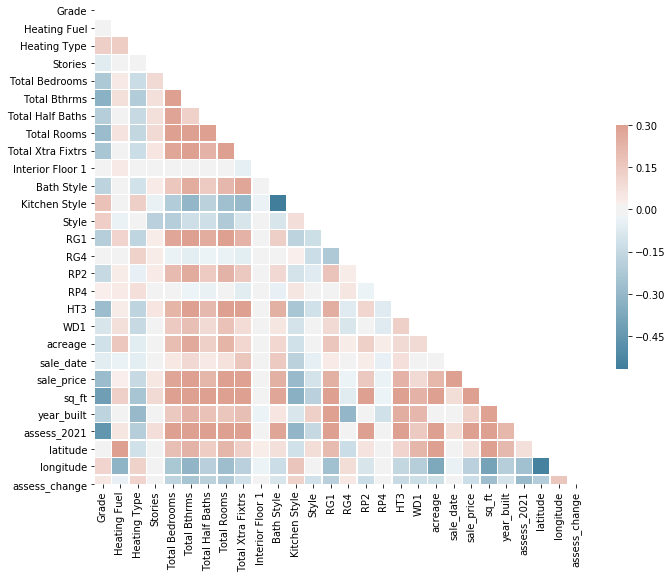

In [16]:
corr = df_model.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

**Nothing is particularly that correlated with the change in assessment.**

This function is used to do cross-validated hyperparameter optimization using the optuna package in each fold below.

In [58]:
## optuna for hyperparameter tuning
def objective(trial, X, y):
    params = {
        "n_estimators" : trial.suggest_int('n_estimators', 0, 500),
        'max_depth':trial.suggest_int('max_depth', 3, 5),
        'reg_alpha':trial.suggest_uniform('reg_alpha',0,6),
        'reg_lambda':trial.suggest_uniform('reg_lambda',0,2),
        'min_child_weight':trial.suggest_int('min_child_weight',0,5),
        'gamma':trial.suggest_uniform('gamma', 0, 4),
        'learning_rate':trial.suggest_loguniform('learning_rate',0.05,0.5),
        'colsample_bytree':trial.suggest_uniform('colsample_bytree',0.4,0.9),
        'subsample':trial.suggest_uniform('subsample',0.4,0.9),
        'nthread' : -1
    }
#     X_train, X_val, y_train, y_val = train_test_split(X, y,
#                                                     test_size=0.25, random_state=42)
#     dtrain = xgb.DMatrix(data=X_train, label=y_train)
#     dval = xgb.DMatrix(data=X_val, label=y_val)
#     regressor = xgb.train(params, dtrain)
#     y_pred = regressor.predict(dval)
#     rmse = mean_squared_error(y_val, y_pred) #,squared=False
    
    xgb_cv_results = xgb.cv(
        num_boost_round=trial.suggest_int("num_boost_rounds",1,100),
        params=params,
        dtrain=xgb.DMatrix(data=X, label=y),
        early_stopping_rounds=100,
        seed=40,
        shuffle=True,
        verbose_eval=False,
        nfold=5)
    
    rmse = xgb_cv_results['test-rmse-mean'].values[-1]

    return rmse

Here I'm building a 5-fold cross-validation XGBoost regression model. For each fold, the model select the best hyperparameters using the held in data, then fits the model using those hyperparameters and the training data. Using this model, I store the predictions and shapley values (for interpretation) for the held out data. This is repeated for each fold so that we have held-out predicted assessment change and shapley values for all the properties.

In [21]:
X = df_model.drop(columns=['assess_change'])
y = df_model['assess_change']

In [59]:
pred_assess = pd.DataFrame(data = {'pred_assess':np.zeros(len(y))}, index=X.index)
shaps = np.zeros(X.shape)
print(pred_assess.shape)

i = 0
t1 = time.time()
KF = KFold(n_splits=5, shuffle=True)
for train_index, test_index in KF.split(range(0,len(y))):
    print('fold: ', i)
    
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]

    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100)
    
    best_params = study.best_params
    best_params['booster'] = 'gbtree'
    best_params['objective'] = 'reg:squarederror'
    
    num_rounds = 1000
    evals_result ={}

    # dtrain = xgb.DMatrix(data=X, label=y)
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    regressor = xgb.train(
        best_params,
        dtrain,
        num_boost_round=num_rounds,
        evals_result=evals_result
    )
    
    dtest = xgb.DMatrix(data=X_test, label=y_test)
    pred_test = regressor.predict(dtest)
    
    pred_assess.iloc[test_index,0] = pred_test
    
    i += 1
    
    explainer = shap.Explainer(regressor)
    shap_values = explainer(X_test)
    shaps[test_index,:] = shap_values.values

t2 = time.time()
print((t2-t1)/60/60)

(18652, 1)
fold:  0
[12:37:10] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:37:10] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:37:10] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to 


[12:37:32] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:37:32] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:37:42] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[12:38:12] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:38:12] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:38:12] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[12:38:28] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:38:33] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:38:33] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[12:39:03] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:39:03] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:39:03] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[12:39:50] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:39:50] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:39:50] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[12:40:24] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:40:24] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:40:34] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[12:41:08] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:41:08] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:41:08] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[12:41:50] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:42:02] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:42:02] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[12:42:35] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:42:35] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:42:35] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[12:43:30] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:43:30] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:43:30] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[12:44:05] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:44:05] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:44:07] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[12:44:45] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:44:45] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:44:45] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[12:45:21] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:45:29] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:45:29] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[12:46:09] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:46:09] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:46:10] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[12:46:56] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:46:56] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:46:56] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[12:47:39] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:47:39] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:47:49] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[12:48:31] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:48:31] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:48:31] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[12:49:24] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:49:35] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:49:35] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[12:50:25] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:50:25] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:50:25] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[12:51:25] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:51:25] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:51:25] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[12:52:19] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:52:19] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:52:33] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[12:54:20] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:54:20] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:54:20] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[12:54:46] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:54:46] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:54:58] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[12:55:38] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:55:38] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:55:38] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[12:56:21] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:56:26] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:56:26] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[12:56:49] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:56:49] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:56:49] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[12:57:43] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:57:43] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:57:43] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[12:58:22] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:58:22] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:58:35] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[12:59:23] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:59:23] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:59:23] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[12:59:54] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:00:05] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:00:05] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:00:44] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:00:44] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:00:44] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:01:33] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:01:33] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:01:33] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:02:19] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:02:19] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:02:30] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:03:15] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:03:15] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:03:15] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:04:00] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:04:09] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:04:09] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:04:54] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:04:54] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:04:54] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:05:45] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:05:45] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:05:45] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:06:33] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:06:33] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:06:43] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:07:19] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:07:19] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:07:19] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:07:59] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:08:09] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:08:09] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:08:47] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:08:47] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:08:47] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:09:40] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:09:40] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:09:40] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:10:20] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:10:20] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:10:29] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:11:15] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:11:15] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:11:15] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:11:25] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:11:25] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:11:37] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:12:00] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:12:00] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:12:00] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:12:35] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:12:44] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:12:44] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:13:22] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:13:22] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:13:22] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:13:56] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:13:56] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:13:56] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:14:33] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:14:33] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:14:38] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:15:17] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:15:17] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:15:18] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:15:51] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:15:57] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:15:57] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:16:29] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:16:29] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:16:29] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:17:12] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:17:12] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:17:13] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:17:42] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:17:42] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:17:53] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:18:26] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:18:26] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:18:26] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:18:55] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:19:04] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:19:04] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:19:46] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:19:46] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:19:46] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:20:37] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:20:37] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:20:37] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:21:17] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:21:17] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:21:27] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:22:07] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:22:07] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:22:07] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:22:41] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:22:50] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:22:50] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:23:28] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:23:28] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:23:28] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:24:15] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:24:15] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:24:15] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:24:49] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:24:49] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:25:01] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:26:09] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:26:09] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:26:09] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:26:29] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:26:29] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:26:37] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:27:06] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:27:06] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:27:06] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:27:41] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:27:45] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:27:45] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:28:04] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:28:04] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:28:05] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:28:32] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:28:32] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:28:32] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:28:56] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:28:56] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:29:04] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:29:28] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:29:28] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:29:29] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:29:57] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:01] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:01] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:30:21] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:21] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:21] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:30:49] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:49] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:49] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:31:11] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:31:11] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:31:15] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:31:35] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:31:35] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:31:35] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:32:00] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:32:08] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:32:08] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:32:41] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:32:41] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:32:41] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:33:25] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:33:25] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:33:25] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:34:08] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:34:08] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:34:18] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:34:55] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:34:55] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:34:55] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:35:35] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:35:44] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:35:44] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:36:19] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:36:19] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:36:20] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:37:08] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:37:08] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:37:08] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:37:45] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:37:45] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:37:56] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators", "num_boost_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to


[13:38:43] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:38:43] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:38:43] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:38:59] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:38:59] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:39:11] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:39:28] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:39:28] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:39:28] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:39:48] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:00] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:00] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:40:17] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:17] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:17] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:40:29] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:29] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:29] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:40:55] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:55] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:58] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:41:18] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:41:18] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:41:18] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:41:37] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:41:45] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:41:45] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:42:04] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:42:04] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:42:04] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:42:29] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:42:29] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:42:29] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:42:57] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:42:57] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:43:05] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:43:35] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:43:35] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:43:35] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:43:57] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:44:04] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:44:04] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:44:28] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:44:28] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:44:28] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:44:59] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:44:59] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:44:59] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:45:24] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:45:24] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:45:29] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:45:53] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:45:53] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:45:53] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:46:17] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:46:23] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:46:23] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:46:47] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:46:47] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:46:47] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s


[13:47:22] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:47:22] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:47:22] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s

Next I look at the predictions from the training data and test data to qualitatively visualize model performance. In general the scatter plot is around the identity line (y=x) suggesting that the model captures the overall trend of the data. The outliers tend to lay a little further from the identity, so estimate on the tails may be less reliable.

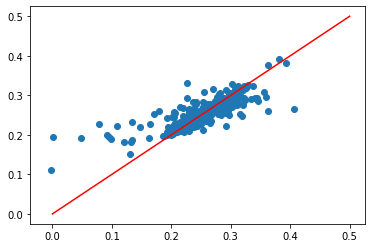

In [76]:
pred_train = regressor.predict(dtrain)
plt.scatter(y_train[1::50], pred_train[1::50])
plt.plot([0, 0.5],[0,0.5], 'r')

Text(0, 0.5, 'predicted % change in assessment')

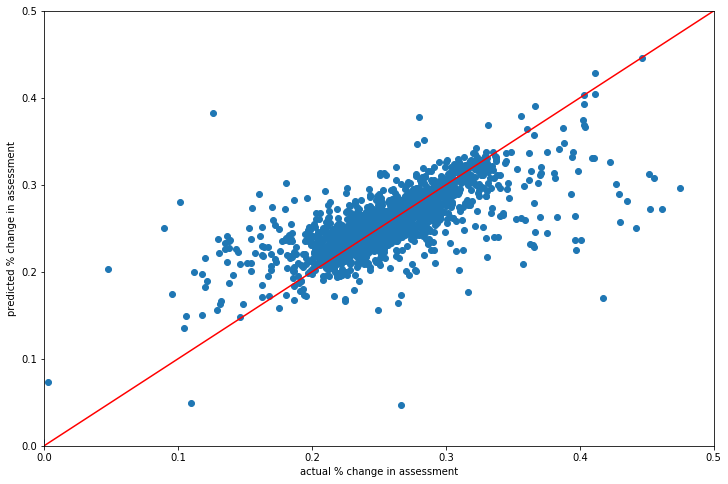

In [89]:
plt.figure(figsize=[12,8])
plt.scatter(y[1::10], pred_assess.pred_assess[1::10])
plt.plot([0, 0.5],[0,0.5], 'r')
plt.xlim([0,0.5])
plt.ylim([0,0.5])
plt.xlabel('actual % change in assessment')
plt.ylabel('predicted % change in assessment')

Saving the predictions to a CSV.

In [86]:
pred_assess_real.address = pred_assess_real.address.str.replace(', Stamford, CT','')
pred_assess_real.to_csv('pred_assess.csv')

Now I will use shapley additive explanations to do some model interpretation. Here's I consider my own house, which has a predicted assement change of 30.1% compared to the actual change of 32.9%. Each row represents one feature, with the colored bar showing how much that feature conributes to the predicted outcome. So for my house, the previous assessment is driving the assessment change higher (+4%), while features like style, acreage and longitude drive the assessment lower.

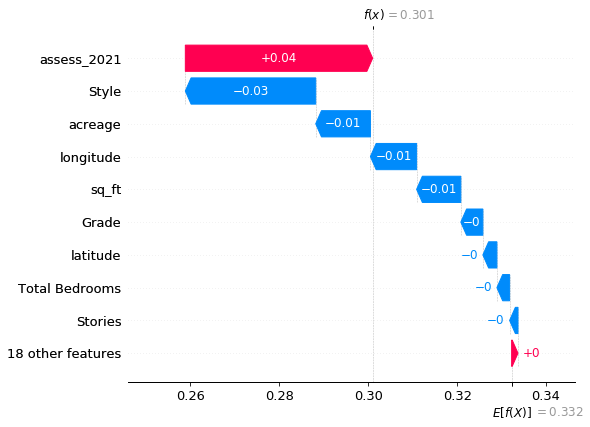

In [153]:
sample_ind = pred_assess_real[pred_assess_real.address.str.contains('50 KNOBLOCH')].index.values
b = pred_assess_real.loc[sample_ind,'pred_assess']-\
    (np.sum(shaps[sample_ind,:]))
s = shap.Explanation(shaps, base_values=b.values[0]*np.ones(shaps.shape[0]), feature_names=X.columns.to_list())
shap.plots.waterfall(s[sample_ind[0]], max_display=10)

In addition I can use SHAP values to look how each feature contributed to the overall model. Here I've ordered the features from most to least important to the model. Each dot represents a single property, and the color of the dot shows whether that feature was relatively high or low for that property. If the dot is on the left of the x-axis, then that value of the feature for the specific property lowered the predicted assessment change. For example, for properties with high latitude, that feature tended to reduce the change in tax assess, which is consistent with the map shown at https://www.shewcraft.com/code.

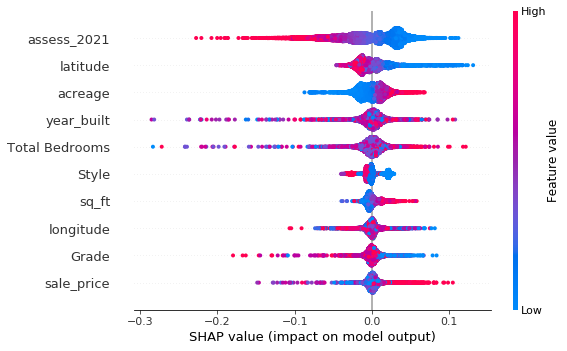

In [128]:
shap.summary_plot(shaps, X, max_display=10)